#### A Simple Inference Demo using the ONNX model format

"""
- A simple inferene  pipeline based on a pretrained image segmentation model based on DeepLabv3+ using Focal loss
- The model was trained on 100 annotated images from https://library.bdrc.io/show/bdr:W2KG229028, using the following classes: background, image, text, margin, caption
- Note: this is an experimental sandbox with regular updates :)
"""

In [26]:
import os
import cv2
import sys
import onnx
import shutil
import random
import requests
import numpy as np
import onnxruntime as ort


from glob import glob
from typing import List, Dict
from natsort import natsorted
from IPython.display import Image

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [20]:
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 1024


#### Download a small Test set

In [ ]:

link_prefix = "https://iiif.bdrc.io/bdr"
test_set_imgs = {
    "I2KG229056": ["I2KG2290560003", "I2KG2290560004", "I2KG2290560015", "I2KG2290560644"],
    "I2KG229060": ["I2KG2290600003", "I2KG2290600551", "I2KG2290600580", "I2KG2290600520"],
}

In [21]:
def build_file_url(manifest_prefix: str, volume: str, image_name: str) -> str:
    return f"{manifest_prefix}:{volume}::{image_name}.jpg/full/max/0/default.jpg"

In [22]:
def download_test_images(test_images: Dict, manifest_prefix: str) -> List[str]:

    if not os.path.exists("tmp"):
        os.makedirs("tmp")

    for volume, images in test_set_imgs.items():
        for image in images:
            url = build_file_url(manifest_prefix, volume, image)
            res = requests.get(url, stream=True)

            if res.status_code == 200:
                out_file = f"tmp/{image}.jpg"

                with open(out_file, "wb") as f:
                    shutil.copyfileobj(res.raw, f)

            else:
                print(f"Error downloading image: {image}")

    test_images = natsorted(glob("tmp/*.jpg"))

    return test_images        

In [29]:
test_images = download_test_images(test_set_imgs, link_prefix)
print(f"Images: {len(test_images)}")

Images: 8


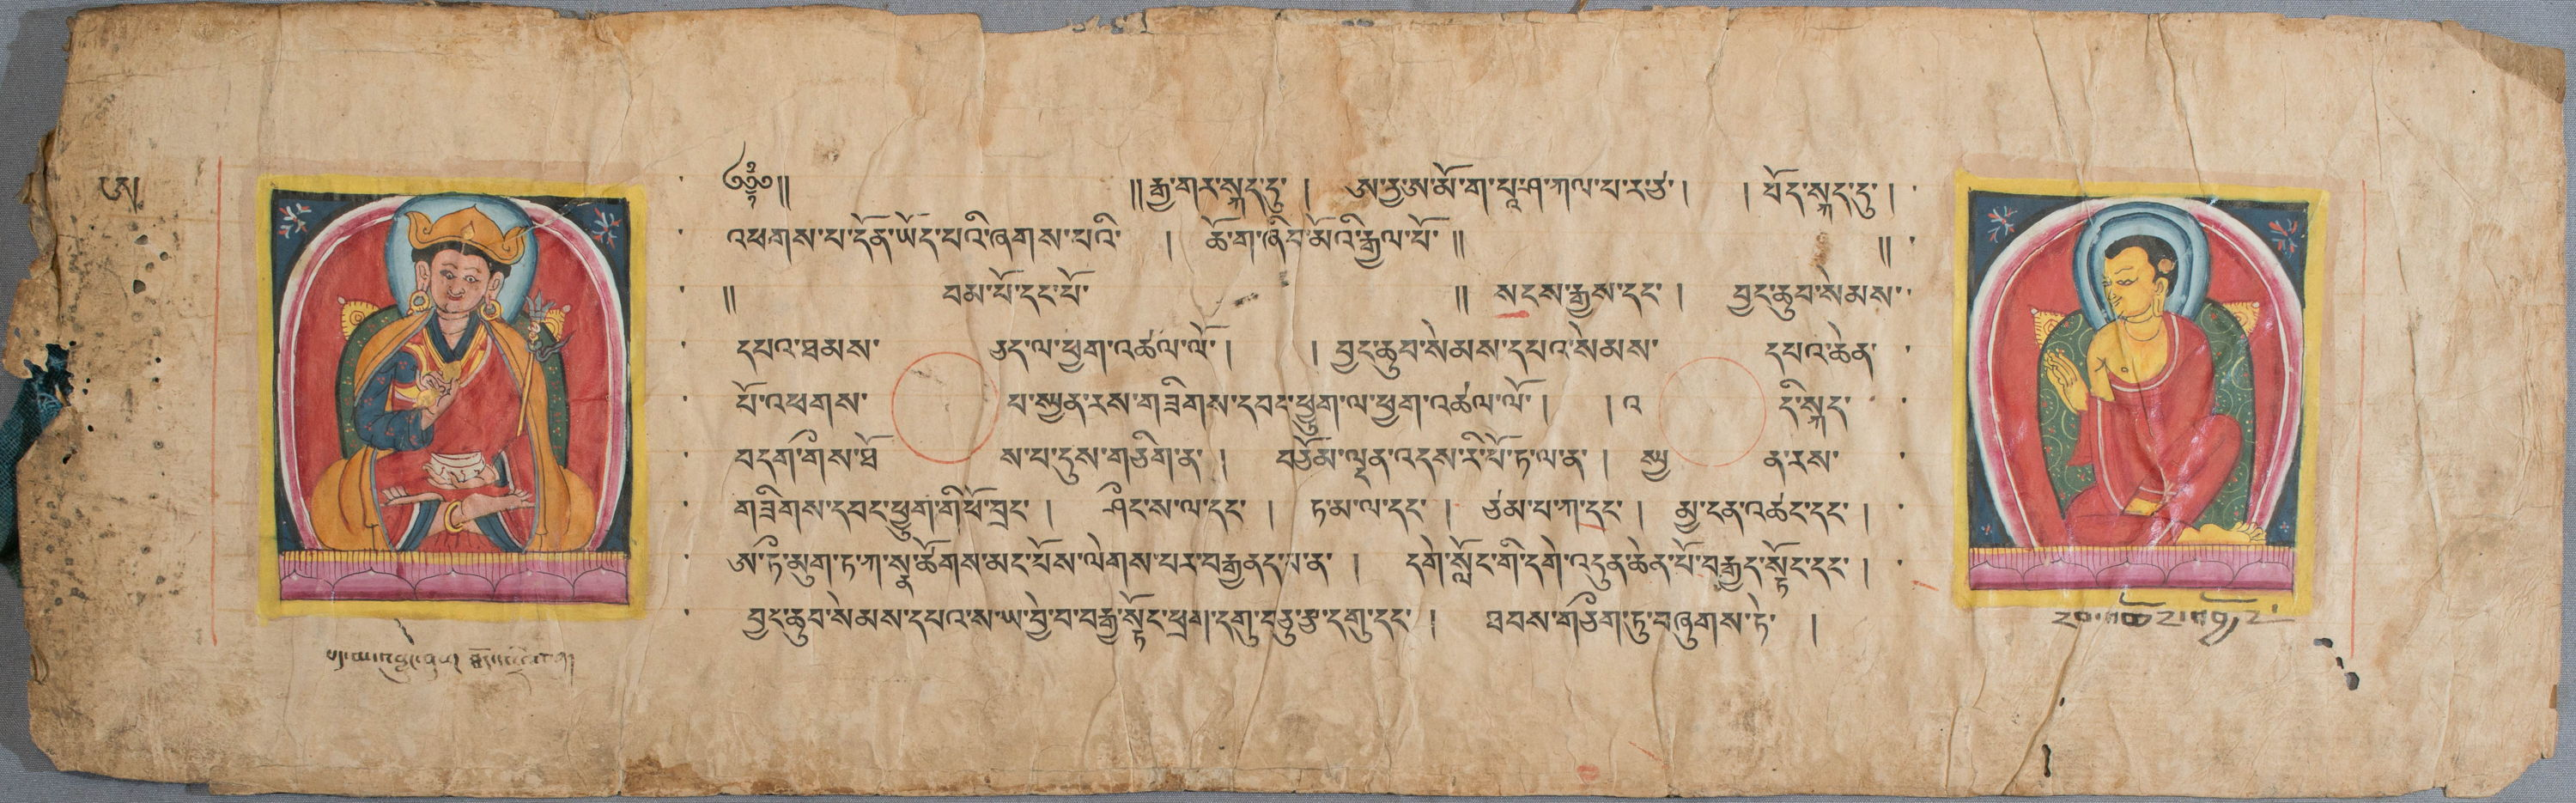

In [38]:
rand_idx = random.randint(0, len(test_images))
Image(test_images[rand_idx])

### Load Model

In [31]:
onnx_path = "OnnxModels\GlomanThang_v1.onnx"
ort_sess = ort.InferenceSession(onnx_path)

In [25]:
def load_image(img_path: str) -> np.array:
    img = cv2.imread(img_path, 1)
    h, w, _ = img.shape
    img = cv2.resize(
        img,
        (
            IMAGE_WIDTH,
            IMAGE_HEIGHT
        ),
    )
    img = img.astype(np.float32)
    img /= 255.0
    img = np.expand_dims(img, axis=0)
    img = np.transpose(img, axes=[0, 3, 1, 2])
    return img

In [39]:
test_img = load_image(test_images[rand_idx])

outputs = ort_sess.run(None, {'input': test_img})
activated_outs = F.softmax(torch.from_numpy(outputs[0]), dim=1)
activated_outs = torch.permute(activated_outs, dims=[0, 2, 3, 1])
activated_outs = torch.squeeze(activated_outs, dim=0)
print(activated_outs.shape)

torch.Size([320, 1024, 5])


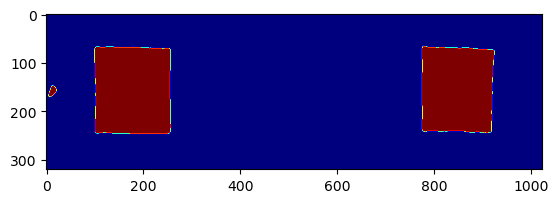

In [41]:
outputs = activated_outs.numpy()
prob_threshold = 0.5

pred_background = np.where(outputs[:, :, 0] > prob_threshold, 1.0, 0)
pred_images = np.where(outputs[:, :, 1] > prob_threshold, 1.0, 0)
pred_text = np.where(outputs[:, :, 2] > prob_threshold, 1.0, 0)
pred_margin = np.where(outputs[:, :, 3] > prob_threshold, 1.0, 0)
pred_caption = np.where(outputs[:, :, 4] > prob_threshold, 1.0, 0)

pred_class = pred_images # change this as you like
plt.imshow(pred_class, cmap="jet")

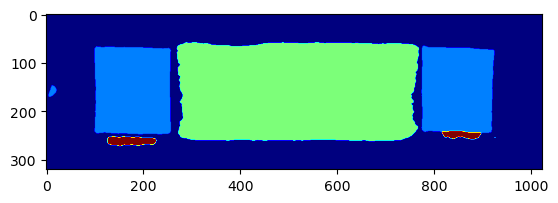

In [65]:
# combined output
combined_output = np.argmax(outputs, axis=-1)
plt.imshow(combined_output, cmap="jet")

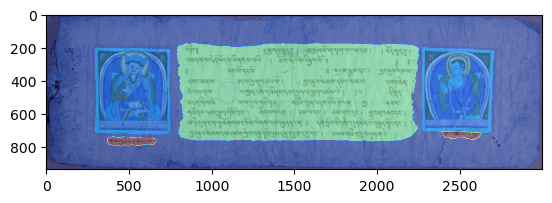

In [66]:
## overlayed display
original_image = cv2.imread((test_images[rand_idx]))
combined_output = combined_output.astype(np.uint8)
preview_outs = cv2.resize(combined_output, ((original_image.shape[1], original_image.shape[0])))

plt.imshow(original_image)
plt.imshow(preview_outs, cmap='jet', alpha=0.4)
